In this experiment i will try to modify the treshold but for that we will be runing the experiment in a smaller sampler so we can had an oportunity to see how it performs in a smaller dataset.

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

enable_code_paths = True

if enable_code_paths:
    URL_path = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/dataset/clean_dataset.csv"
    URL_path_save = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model"
    URL_helper ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/helper/"
else :
    URL_path = "/content/drive/MyDrive/turing_college_experiments/14_NLP/helper"
    URL_path_save = "/content/drive/MyDrive/turing_college_experiments/14_NLP/model"
    URL_helper = "/content/drive/MyDrive/turing_college_experiments/14_NLP/helper"
import sys
sys.path.append(URL_helper)

from colab_helper import proportion_balance_classes

Mounted at /content/drive


Now we will be installing all the modules that are required

In [3]:
%%capture
!pip install torchinfo

We will be exploring the Bert model and see if we could find any good performance

In [4]:
# Main Libraries
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

# PyTorch Libraries
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torchinfo import summary  # Model summary tool for PyTorch

# Transformers Library (for BERT and related utilities)
from transformers import BertTokenizer, BertModel, BertConfig

# Evaluation and Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# colorama
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)
theme_color

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

In [5]:
dataframe = pd.read_csv(URL_path)
# dataframe["not_toxic"] = ((dataframe.iloc[:, 1:] == 0).all(axis=1)).astype(int)
dataframe.head()


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,ExplanationWhy the edits made under my usernam...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""MoreI can't make any real suggestions on impr...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


tensor([0.4357, 0.0435, 0.2409, 0.0137, 0.2262, 0.0400])
total samples 144790


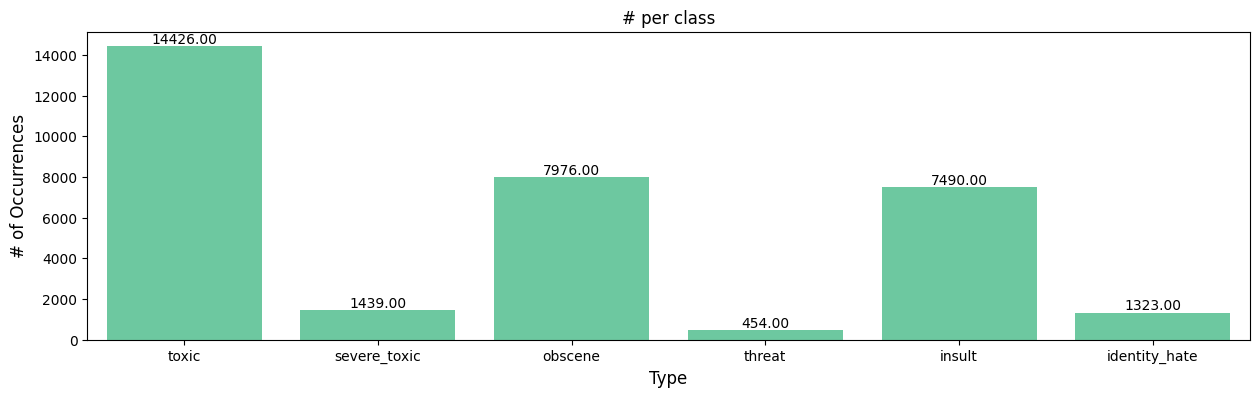

In [6]:
target_y =dataframe.iloc[:,1:].sum()

weights_list = target_y.tolist()
weights = torch.tensor(weights_list, dtype=torch.float32)
normalized_weights = weights / weights.sum()
print(normalized_weights)

print(f"total samples {dataframe.shape[0]}")
proportion_balance_classes(target_y.index, target_y.values)

In this approach, we’ll use class weights without including all samples from the dataset, aiming to achieve better results by working with a subset of the data.

Now that we had a smaller dataset with all the data around the same balance, we will try to

In [7]:
dataframe['list'] = dataframe[dataframe.columns[1:]].values.tolist()
dataframe_clean = dataframe[['comment_text', 'list']].copy()
dataframe_clean.head()

,comment_text,list
0,ExplanationWhy the edits made under my usernam...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""MoreI can't make any real suggestions on impr...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


# Dataset Parameters and model selection
- **MAX_LEN**: Maximum length of the tokenized sequences
- **TRAIN_BATCH_SIZE**: Batch size for the training set
- **VALID_BATCH_SIZE**: Batch size for the validation set


Then we select the BERT model

In [8]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
SAMPLE_PERCENTAGE = 0.30


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
class CustomDataset(Dataset):
    """Tokenize the dataset for using it in the model"""
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,                     # The text to encode
            None,                              # Optional second input (e.g., for sentence pairs)
            add_special_tokens=True,           # Add special tokens ([CLS], [SEP])
            max_length=self.max_len,           # Truncate to max_len if necessary
            padding='max_length',              # Pad the sequence to max_len
            truncation=True,                   # Truncate if longer than max_len
            return_token_type_ids=True        # Return token type IDs
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        values_return = {
                        'ids': torch.tensor(ids, dtype=torch.int64),
                        'mask': torch.tensor(mask, dtype=torch.int64),
                        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.int64),
                        'targets': torch.tensor(self.targets[index], dtype=torch.float)
                         }

        return values_return

# split and dataloader

We divided the dataset into 90% for training and 10% for validation in order to assess potential improvements in performance.


In [10]:
# sample sisze

dataframe_clean=dataframe_clean.sample(frac=SAMPLE_PERCENTAGE,random_state=42)

# split
train_size = 0.8
train_dataset=dataframe_clean.sample(frac=train_size,random_state=42)
test_dataset=dataframe_clean.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(dataframe_clean.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

# transforming the dataset
training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

# dataloader
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

FULL Dataset: (43437, 2)
TRAIN Dataset: (34750, 2)
TEST Dataset: (8687, 2)


----------

# Fine tune the model

In [11]:
class BertClass(torch.nn.Module):
    def __init__(self):
        super(BertClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Linear(768, 256)
        self.l3 = torch.nn.Dropout(0.3)
        # because we are trying to predict 6 classes
        self.l4 = torch.nn.Linear(256, 6)

        # freeze the layers
        for param in self.l1.parameters():
            param.requires_grad = False
        for param in self.l1.encoder.layer[-1].parameters():
            param.requires_grad = True

        # name of the layers
        self.layer_names = {
            'bert_model': self.l1,
            'reducing_size': self.l2,
            'dropout': self.l3,
            'output_layer': self.l4,
        }

    def forward(self, ids, mask, token_type_ids):

        assert isinstance(ids, torch.Tensor), f"Expected tensor, got {type(ids)} for ids"
        assert isinstance(mask, torch.Tensor), f"Expected tensor, got {type(mask)} for mask"
        assert isinstance(token_type_ids, torch.Tensor), f"Expected tensor, got {type(token_type_ids)} for token_type_ids"

        output_1 = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output_1 = output_1[1]
        output_2 = self.l2(output_1)
        output_3 = self.l3(output_2)
        output = self.l4(output_3)
        return output

model_bert = BertClass()
model_bert.to(device)

summary(model_bert)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Layer (type:depth-idx)                                  Param #
BertClass                                               --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─Embedding: 3-3                              (1,536)
│    │    └─LayerNorm: 3-4                              (1,536)
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 (590,592)
│    │    └─Tanh: 3-8                                   --
├─Linear: 1-2                                           196,864
├─Dropout: 1-3                                          --
├─Li

We will be looking now the freezing layers to undestand which once the model need to be trainable

In [12]:
def get_freeze_status_df(model):
    """ Returns a DataFrame indicating whether each layer is trainable or frozen. """
    freeze_status = []
    for name, param in model.named_parameters():
        freeze_status.append({
            'Layer Name': name,
            'Trainable': param.requires_grad
        })

    return pd.DataFrame(freeze_status)

# Call the function
freeze_status_df = get_freeze_status_df(model_bert)
freeze_status_df[freeze_status_df["Trainable"] == True ]

,Layer Name,Trainable
181,l1.encoder.layer.11.attention.self.query.weight,True
182,l1.encoder.layer.11.attention.self.query.bias,True
183,l1.encoder.layer.11.attention.self.key.weight,True
184,l1.encoder.layer.11.attention.self.key.bias,True
185,l1.encoder.layer.11.attention.self.value.weight,True
186,l1.encoder.layer.11.attention.self.value.bias,True
187,l1.encoder.layer.11.attention.output.dense.weight,True
188,l1.encoder.layer.11.attention.output.dense.bias,True
189,l1.encoder.layer.11.attention.output.LayerNorm...,True
190,l1.encoder.layer.11.attention.output.LayerNorm...,True


 # Parameters model

In this case, we selected 256 as the maximum token length because values above this threshold represent only about 5% of the data, making them statistically insignificant. Removing these outliers helps streamline training and improve efficiency. For this iteration, we will use training and validation batches of 8 and 4, with an initial learning rate set at 1e-04. The first model we will be testing is BERT.

In [13]:
EPOCHS = 4
LEARNING_RATE = 1e-04
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# name of the model to save
model_name_to_save = "007_model_bert_threshold"

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# train the model

In [14]:
# Loss function
loss_fun_object = torch.nn.BCEWithLogitsLoss(pos_weight=normalized_weights)
def loss_fn(outputs, targets):
    return loss_fun_object(outputs, targets)

# Optimizer
param_groups = [
    {'params': model_bert.l1.parameters(), 'lr': LEARNING_RATE * 0.1},
    {'params': model_bert.l3.parameters(), 'lr': LEARNING_RATE},
]

# Create the optimizer using AdamW with parameter groups
optimizer = torch.optim.AdamW(param_groups, weight_decay=0.001)

# Store loss, accuracy, and recall
def calculate_accuracy(outputs, targets, threshold=0.5):
    if isinstance(outputs, np.ndarray):
        outputs = torch.tensor(outputs)
    preds = torch.sigmoid(outputs)
    preds = (preds >= threshold).float()
    correct_preds = (preds == targets).float()
    accuracy_per_sample = correct_preds.mean(dim=1)
    return accuracy_per_sample.mean().item()

def calculate_recall(outputs, targets, threshold=0.5):
    if isinstance(outputs, np.ndarray):
        outputs = torch.tensor(outputs)
    preds = torch.sigmoid(outputs)
    preds = (preds >= threshold).float()
    true_positives = (preds * targets).sum(dim=0)
    false_negatives = ((1 - preds) * targets).sum(dim=0)
    recall_per_label = true_positives / (true_positives + false_negatives + 1e-10)
    return recall_per_label.mean().item()

# Initialize history lists
loss_history = []
accuracy_history = []
recall_history = []

# Training function
def train(epoch, model, dataset_loader, device, threshold):
    """ Train the model """
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    running_recall = 0.0
    total_samples = 0

    # Iterate through the batches
    for _, data in tqdm(enumerate(dataset_loader, 0), total=len(dataset_loader)):
        ids = data['ids'].to(device, dtype=torch.int32  )
        mask = data['mask'].to(device, dtype=torch.int32  )
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.int64)
        targets = data['targets'].to(device, dtype=torch.float32)  # Use float for BCEWithLogitsLoss

        # Forward pass
        outputs = model(ids, mask, token_type_ids)

        # Compute loss and backpropagate
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item() * ids.size(0)  # Scale by batch size
        running_accuracy += calculate_accuracy(outputs, targets, threshold) * ids.size(0)
        running_recall += calculate_recall(outputs, targets, threshold) * ids.size(0)
        total_samples += ids.size(0)

    # Compute epoch-level metrics
    epoch_loss = running_loss / total_samples
    epoch_accuracy = running_accuracy / total_samples
    epoch_recall = running_recall / total_samples
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)
    recall_history.append(epoch_recall)

    print(f"Epoch {epoch} - Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}, Training Recall: {epoch_recall:.4f}")
    return model, loss_history, accuracy_history, recall_history

We will use fewer epochs than in previous experiments, but we will monitor their performance closely.

# Validation set

In [15]:
loss_values = []
accuracy_values = []
recall_values = []  # Initialize a list to store recall values

def validation(epoch, model, dataloader, device, loss_fun, threshold_target=0.5):
    model.eval()  # Set model to evaluation mode
    fin_targets = []
    fin_outputs = []
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for _, data in tqdm(enumerate(dataloader, 0), total=len(dataloader)):
            ids = data['ids'].to(device, dtype=torch.int32  )
            mask = data['mask'].to(device, dtype=torch.int32  )
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.int64)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_fun(outputs, targets)  # Calculate loss
            total_loss += loss.item() * ids.size(0)
            total_samples += ids.size(0)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    # Calculate average loss over the entire validation set
    avg_loss = total_loss / total_samples
    fin_outputs = (np.array(fin_outputs) > threshold_target).astype(int)
    fin_targets = np.array(fin_targets)

    accuracy = calculate_accuracy(fin_outputs, fin_targets, threshold_target)
    recall = calculate_recall(fin_outputs, fin_targets, threshold_target)

    loss_values.append(avg_loss)
    accuracy_values.append(accuracy)
    recall_values.append(recall)  # Append recall to the list

    print(f"Epoch {epoch} - Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}, Validation Recall: {recall:.4f}")
    return fin_outputs, fin_targets, loss_values, accuracy_values, recall_values


# Epochs
We will run multiple iterations and observe how the model responds as training progresses.

In [24]:
# Initialize dictionaries to store results
threshold_results = {
    'threshold': [],
    'epoch': [],
    'train_loss': [],
    'train_accuracy': [],
    'train_recall': [],
    'valid_loss': [],
    'valid_accuracy': [],
    'valid_recall': []
}

# Threshold spaces
np.random.seed(42)
random_threshold = np.random.uniform(0.35, 0.9, 3)
threshold_list = np.sort(random_threshold)
threshold_list = np.round(threshold_list, 2)

# Loop over thresholds
for threshold in threshold_list:
    print(f"Threshold: {threshold}")
    print("===========================")

    for epoch in range(EPOCHS):

        # Training Phase
        print("=== Training ===")
        start_time = time.time()
        model_bert, loss_history_train, accuracy_history_train, recall_history_train = train(epoch, model_bert, training_loader, device, threshold)

        # Store last value in the histories for the current epoch
        train_loss = loss_history_train[-1]
        train_accuracy = accuracy_history_train[-1]
        train_recall = recall_history_train[-1]

        # Testing/Validation Phase
        print("=== Testing ===")
        outputs, targets, loss_history_valid, accuracy_history_valid, recall_history_valid = validation(epoch, model_bert, testing_loader, device, loss_fun_object, threshold)

        # Store last value in the validation histories for the current epoch
        valid_loss = loss_history_valid[-1]
        valid_accuracy = accuracy_history_valid[-1]
        valid_recall = recall_history_valid[-1]

        # Save results in dictionary
        threshold_results['threshold'].append(threshold)
        threshold_results['epoch'].append(epoch)
        threshold_results['train_loss'].append(train_loss)
        threshold_results['train_accuracy'].append(train_accuracy)
        threshold_results['train_recall'].append(train_recall)
        threshold_results['valid_loss'].append(valid_loss)
        threshold_results['valid_accuracy'].append(valid_accuracy)
        threshold_results['valid_recall'].append(valid_recall)

        end_time = time.time()
        epoch_duration = end_time - start_time
        print(f'Epoch {epoch + 1}/{EPOCHS} completed in {epoch_duration:.2f} seconds.')
        print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Recall: {train_recall:.4f}")
        print(f"Validation - Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.4f}, Recall: {valid_recall:.4f}")

    # Save the model after each epoch with threshold value in the name
    model_save_path = f"model_epoch_{epoch+1}_threshold_{threshold:.2f}.pt"
    torch.save(model_bert.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")
    print(f"==================================")


Threshold: 0.56
=== Training ===


100%|██████████| 4344/4344 [20:44<00:00,  3.49it/s]


Epoch 0 - Training Loss: 0.3483, Training Accuracy: 0.9603, Training Recall: 0.0009
=== Testing ===


100%|██████████| 2172/2172 [04:51<00:00,  7.44it/s]


Epoch 0 - Validation Loss: 0.3119, Validation Accuracy: 0.9636, Validation Recall: 0.0170
Epoch 1/4 completed in 1536.93 seconds.
Training - Loss: 0.3483, Accuracy: 0.9603, Recall: 0.0009
Validation - Loss: 0.3119, Accuracy: 0.9636, Recall: 0.0170
=== Training ===


100%|██████████| 4344/4344 [21:04<00:00,  3.43it/s]


Epoch 1 - Training Loss: 0.3127, Training Accuracy: 0.9660, Training Recall: 0.0272
=== Testing ===


100%|██████████| 2172/2172 [04:49<00:00,  7.49it/s]


Epoch 1 - Validation Loss: 0.2940, Validation Accuracy: 0.9692, Validation Recall: 0.0881
Epoch 2/4 completed in 1554.76 seconds.
Training - Loss: 0.3127, Accuracy: 0.9660, Recall: 0.0272
Validation - Loss: 0.2940, Accuracy: 0.9692, Recall: 0.0881
=== Training ===


100%|██████████| 4344/4344 [21:05<00:00,  3.43it/s]


Epoch 2 - Training Loss: 0.2957, Training Accuracy: 0.9675, Training Recall: 0.0349
=== Testing ===


100%|██████████| 2172/2172 [04:47<00:00,  7.56it/s]


Epoch 2 - Validation Loss: 0.2786, Validation Accuracy: 0.9685, Validation Recall: 0.0763
Epoch 3/4 completed in 1552.58 seconds.
Training - Loss: 0.2957, Accuracy: 0.9675, Recall: 0.0349
Validation - Loss: 0.2786, Accuracy: 0.9685, Recall: 0.0763
=== Training ===


100%|██████████| 4344/4344 [20:41<00:00,  3.50it/s]


Epoch 3 - Training Loss: 0.2806, Training Accuracy: 0.9683, Training Recall: 0.0413
=== Testing ===


100%|██████████| 2172/2172 [04:42<00:00,  7.70it/s]


Epoch 3 - Validation Loss: 0.2646, Validation Accuracy: 0.9691, Validation Recall: 0.0858
Epoch 4/4 completed in 1523.48 seconds.
Training - Loss: 0.2806, Accuracy: 0.9683, Recall: 0.0413
Validation - Loss: 0.2646, Accuracy: 0.9691, Recall: 0.0858
Model saved to model_epoch_4_threshold_0.56.pt
Threshold: 0.75
=== Training ===


100%|██████████| 4344/4344 [20:50<00:00,  3.47it/s]


Epoch 0 - Training Loss: 0.2669, Training Accuracy: 0.9614, Training Recall: 0.0000
=== Testing ===


100%|██████████| 2172/2172 [04:48<00:00,  7.52it/s]


Epoch 0 - Validation Loss: 0.2519, Validation Accuracy: 0.9619, Validation Recall: 0.0000
Epoch 1/4 completed in 1539.63 seconds.
Training - Loss: 0.2669, Accuracy: 0.9614, Recall: 0.0000
Validation - Loss: 0.2519, Accuracy: 0.9619, Recall: 0.0000
=== Training ===


100%|██████████| 4344/4344 [20:54<00:00,  3.46it/s]


Epoch 1 - Training Loss: 0.2545, Training Accuracy: 0.9614, Training Recall: 0.0000
=== Testing ===


100%|██████████| 2172/2172 [04:47<00:00,  7.55it/s]


Epoch 1 - Validation Loss: 0.2406, Validation Accuracy: 0.9619, Validation Recall: 0.0000
Epoch 2/4 completed in 1542.17 seconds.
Training - Loss: 0.2545, Accuracy: 0.9614, Recall: 0.0000
Validation - Loss: 0.2406, Accuracy: 0.9619, Recall: 0.0000
=== Training ===


100%|██████████| 4344/4344 [20:50<00:00,  3.47it/s]


Epoch 2 - Training Loss: 0.2433, Training Accuracy: 0.9615, Training Recall: 0.0001
=== Testing ===


100%|██████████| 2172/2172 [04:50<00:00,  7.48it/s]


Epoch 2 - Validation Loss: 0.2298, Validation Accuracy: 0.9619, Validation Recall: 0.0000
Epoch 3/4 completed in 1541.08 seconds.
Training - Loss: 0.2433, Accuracy: 0.9615, Recall: 0.0001
Validation - Loss: 0.2298, Accuracy: 0.9619, Recall: 0.0000
=== Training ===


100%|██████████| 4344/4344 [20:34<00:00,  3.52it/s]


Epoch 3 - Training Loss: 0.2331, Training Accuracy: 0.9615, Training Recall: 0.0001
=== Testing ===


100%|██████████| 2172/2172 [04:40<00:00,  7.74it/s]


Epoch 3 - Validation Loss: 0.2202, Validation Accuracy: 0.9619, Validation Recall: 0.0000
Epoch 4/4 completed in 1514.96 seconds.
Training - Loss: 0.2331, Accuracy: 0.9615, Recall: 0.0001
Validation - Loss: 0.2202, Accuracy: 0.9619, Recall: 0.0000
Model saved to model_epoch_4_threshold_0.75.pt
Threshold: 0.87
=== Training ===


100%|██████████| 4344/4344 [20:53<00:00,  3.47it/s]


Epoch 0 - Training Loss: 0.2237, Training Accuracy: 0.9614, Training Recall: 0.0000
=== Testing ===


100%|██████████| 2172/2172 [04:47<00:00,  7.57it/s]


Epoch 0 - Validation Loss: 0.2114, Validation Accuracy: 0.9619, Validation Recall: 0.0000
Epoch 1/4 completed in 1540.32 seconds.
Training - Loss: 0.2237, Accuracy: 0.9614, Recall: 0.0000
Validation - Loss: 0.2114, Accuracy: 0.9619, Recall: 0.0000
=== Training ===


100%|██████████| 4344/4344 [20:52<00:00,  3.47it/s]


Epoch 1 - Training Loss: 0.2151, Training Accuracy: 0.9614, Training Recall: 0.0000
=== Testing ===


100%|██████████| 2172/2172 [04:55<00:00,  7.35it/s]


Epoch 1 - Validation Loss: 0.2036, Validation Accuracy: 0.9619, Validation Recall: 0.0000
Epoch 2/4 completed in 1548.28 seconds.
Training - Loss: 0.2151, Accuracy: 0.9614, Recall: 0.0000
Validation - Loss: 0.2036, Accuracy: 0.9619, Recall: 0.0000
=== Training ===


100%|██████████| 4344/4344 [21:13<00:00,  3.41it/s]


Epoch 2 - Training Loss: 0.2070, Training Accuracy: 0.9614, Training Recall: 0.0000
=== Testing ===


100%|██████████| 2172/2172 [04:46<00:00,  7.57it/s]


Epoch 2 - Validation Loss: 0.1959, Validation Accuracy: 0.9619, Validation Recall: 0.0000
Epoch 3/4 completed in 1560.83 seconds.
Training - Loss: 0.2070, Accuracy: 0.9614, Recall: 0.0000
Validation - Loss: 0.1959, Accuracy: 0.9619, Recall: 0.0000
=== Training ===


100%|██████████| 4344/4344 [21:57<00:00,  3.30it/s]


Epoch 3 - Training Loss: 0.1997, Training Accuracy: 0.9614, Training Recall: 0.0000
=== Testing ===


100%|██████████| 2172/2172 [04:43<00:00,  7.67it/s]


Epoch 3 - Validation Loss: 0.1890, Validation Accuracy: 0.9619, Validation Recall: 0.0000
Epoch 4/4 completed in 1600.70 seconds.
Training - Loss: 0.1997, Accuracy: 0.9614, Recall: 0.0000
Validation - Loss: 0.1890, Accuracy: 0.9619, Recall: 0.0000
Model saved to model_epoch_4_threshold_0.87.pt


In [25]:
threshold_results_df = pd.DataFrame(threshold_results)
threshold_results_df

,threshold,epoch,train_loss,train_accuracy,train_recall,valid_loss,valid_accuracy,valid_recall
0,0.56,0,0.348296,0.960331,0.000867,0.311898,0.963585,0.017043
1,0.56,1,0.312694,0.966043,0.027162,0.294011,0.969207,0.088085
2,0.56,2,0.295703,0.967520,0.034875,0.278630,0.968497,0.076346
3,0.56,3,0.280624,0.968326,0.041278,0.264581,0.969149,0.085774
4,0.75,0,0.266875,0.961444,0.000000,0.251882,0.961936,0.000000
5,0.75,1,0.254545,0.961444,0.000000,0.240566,0.961935,0.000000
6,0.75,2,0.243306,0.961453,0.000058,0.229809,0.961935,0.000000
7,0.75,3,0.233090,0.961453,0.000077,0.220239,0.961936,0.000000
8,0.87,0,0.223722,0.961444,0.000000,0.211378,0.961935,0.000000
9,0.87,1,0.215142,0.961444,0.000000,0.203562,0.961935,0.000000


In [26]:
import plotly.graph_objects as go
import pandas as pd

# Sample range for epochs
epochs = list(range(1, EPOCHS + 1))

# Create a figure for each metric (Loss, Accuracy, Recall)
fig = go.Figure()


for threshold in threshold_list:
    # Filter results for the current threshold using DataFrame filtering
    threshold_data = threshold_results_df[threshold_results_df['threshold'] == threshold]

    # Extract loss values for the current threshold
    loss_values = threshold_data['train_loss'].values
    val_loss_values = threshold_data['valid_loss'].values

    # Add traces for Training Loss
    fig.add_trace(go.Scatter(
        x=epochs, y=loss_values, mode='lines+markers', name=f"Train Loss (Threshold={threshold:.2f})",
        line=dict(dash="solid"), marker=dict(symbol="circle")
    ))

    # Add traces for Validation Loss
    fig.add_trace(go.Scatter(
        x=epochs, y=val_loss_values, mode='lines+markers', name=f"Val Loss (Threshold={threshold:.2f})",
        line=dict(dash="dash"), marker=dict(symbol="circle")
    ))

# Update layout for Loss plot
fig.update_layout(
    title="Training and Validation Loss by Epoch and Threshold",
    xaxis_title="Epochs",
    yaxis_title="Loss",
    showlegend=True
)
fig.show()

# Plot Training and Validation Accuracy for Different Thresholds
fig = go.Figure()

for threshold in threshold_list:
    threshold_data = threshold_results_df[threshold_results_df['threshold'] == threshold]

    # Extract accuracy values for the current threshold
    accuracy_values = threshold_data['train_accuracy'].values
    val_accuracy_values = threshold_data['valid_accuracy'].values

    fig.add_trace(go.Scatter(
        x=epochs, y=accuracy_values, mode='lines+markers', name=f"Train Accuracy (Threshold={threshold:.2f})",
        line=dict(dash="solid"), marker=dict(symbol="circle")
    ))

    fig.add_trace(go.Scatter(
        x=epochs, y=val_accuracy_values, mode='lines+markers', name=f"Val Accuracy (Threshold={threshold:.2f})",
        line=dict(dash="dash"), marker=dict(symbol="circle")
    ))

fig.update_layout(
    title="Training and Validation Accuracy by Epoch and Threshold",
    xaxis_title="Epochs",
    yaxis_title="Accuracy",
    showlegend=True
)
fig.show()

# Plot Training and Validation Recall for Different Thresholds
fig = go.Figure()

for threshold in threshold_list:
    threshold_data = threshold_results_df[threshold_results_df['threshold'] == threshold]

    # Extract recall values for the current threshold
    recall_values = threshold_data['train_recall'].values
    val_recall_values = threshold_data['valid_recall'].values

    fig.add_trace(go.Scatter(
        x=epochs, y=recall_values, mode='lines+markers', name=f"Train Recall (Threshold={threshold:.2f})",
        line=dict(dash="solid"), marker=dict(symbol="circle")
    ))

    fig.add_trace(go.Scatter(
        x=epochs, y=val_recall_values, mode='lines+markers', name=f"Val Recall (Threshold={threshold:.2f})",
        line=dict(dash="dash"), marker=dict(symbol="circle")
    ))

fig.update_layout(
    title="Training and Validation Recall by Epoch and Threshold",
    xaxis_title="Epochs",
    yaxis_title="Recall",
    showlegend=True
)
fig.show()

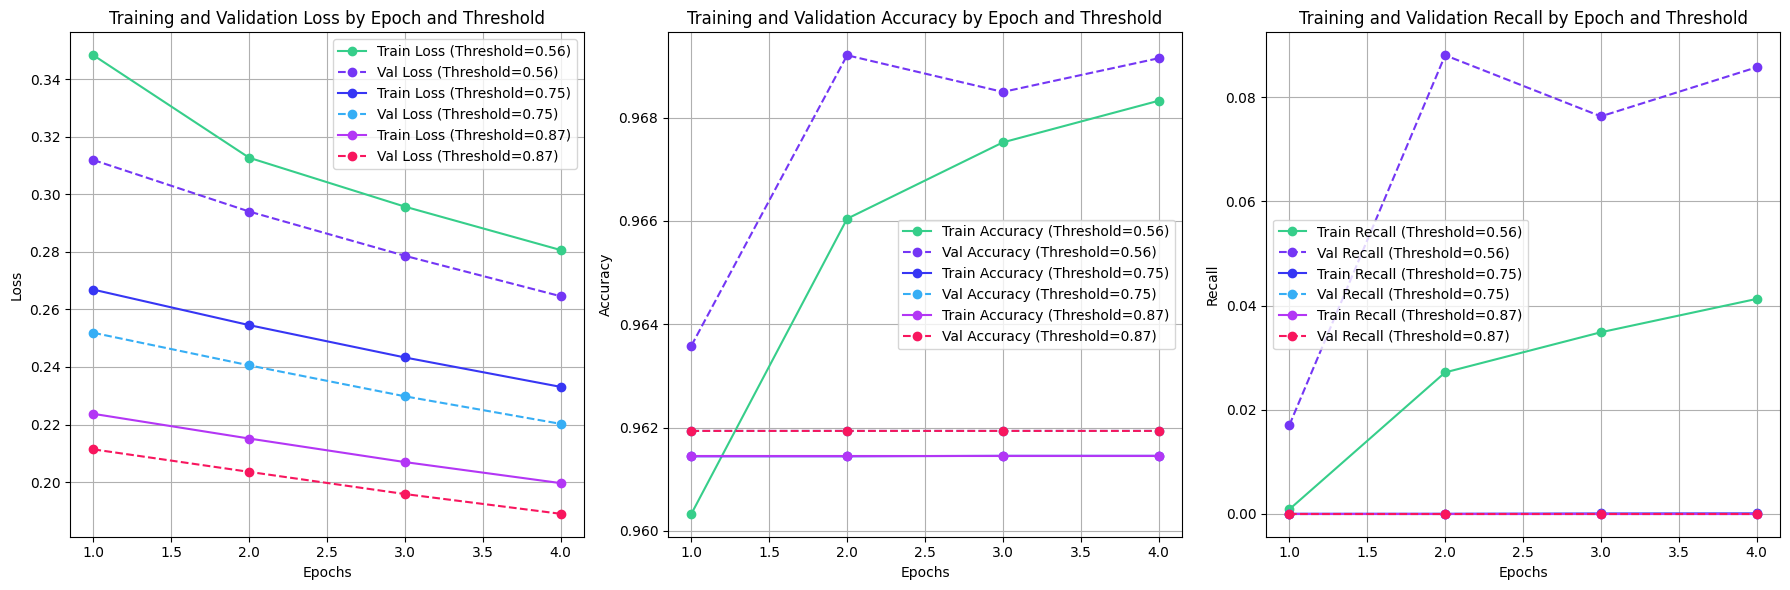

In [27]:
# Sample range for epochs
epochs = range(1, EPOCHS + 1)

# Plot for all thresholds
plt.figure(figsize=(18, 6))



# Plot Loss for Different Thresholds
plt.subplot(1, 3, 1)
for threshold in threshold_list:
    # Filter the DataFrame for the current threshold
    threshold_data = threshold_results_df[threshold_results_df['threshold'] == threshold]

    # Extract loss values for the current threshold
    loss_values = threshold_data['train_loss'].values
    val_loss_values = threshold_data['valid_loss'].values

    # Plot training and validation loss
    plt.plot(epochs, loss_values, label=f"Train Loss (Threshold={threshold:.2f})", marker='o')
    plt.plot(epochs, val_loss_values, label=f"Val Loss (Threshold={threshold:.2f})", linestyle='--', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss by Epoch and Threshold")
plt.legend()
plt.grid(True)

# Plot Accuracy for Different Thresholds
plt.subplot(1, 3, 2)
for threshold in threshold_list:
    # Filter the DataFrame for the current threshold
    threshold_data = threshold_results_df[threshold_results_df['threshold'] == threshold]

    # Extract accuracy values for the current threshold
    accuracy_values = threshold_data['train_accuracy'].values
    val_accuracy_values = threshold_data['valid_accuracy'].values

    # Plot training and validation accuracy
    plt.plot(epochs, accuracy_values, label=f"Train Accuracy (Threshold={threshold:.2f})", marker='o')
    plt.plot(epochs, val_accuracy_values, label=f"Val Accuracy (Threshold={threshold:.2f})", linestyle='--', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy by Epoch and Threshold")
plt.legend()
plt.grid(True)

# Plot Recall for Different Thresholds
plt.subplot(1, 3, 3)
for threshold in threshold_list:
    # Filter the DataFrame for the current threshold
    threshold_data = threshold_results_df[threshold_results_df['threshold'] == threshold]

    # Extract recall values for the current threshold
    recall_values = threshold_data['train_recall'].values
    val_recall_values = threshold_data['valid_recall'].values

    # Plot training and validation recall
    plt.plot(epochs, recall_values, label=f"Train Recall (Threshold={threshold:.2f})", marker='o')
    plt.plot(epochs, val_recall_values, label=f"Val Recall (Threshold={threshold:.2f})", linestyle='--', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Training and Validation Recall by Epoch and Threshold")
plt.legend()
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Threshold: 0.56


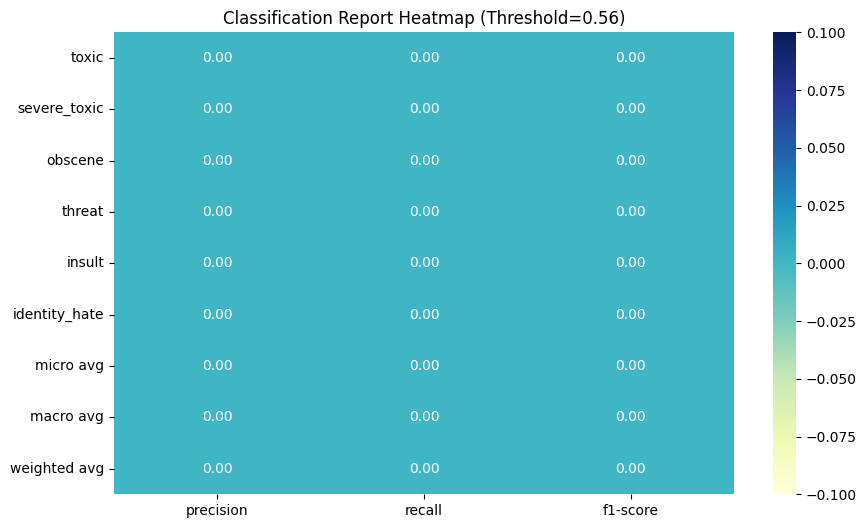

Threshold: 0.75


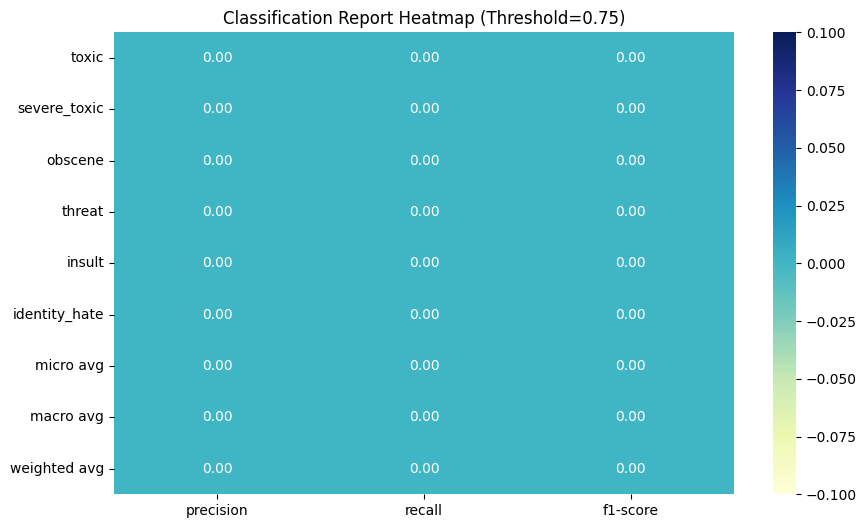

Threshold: 0.87


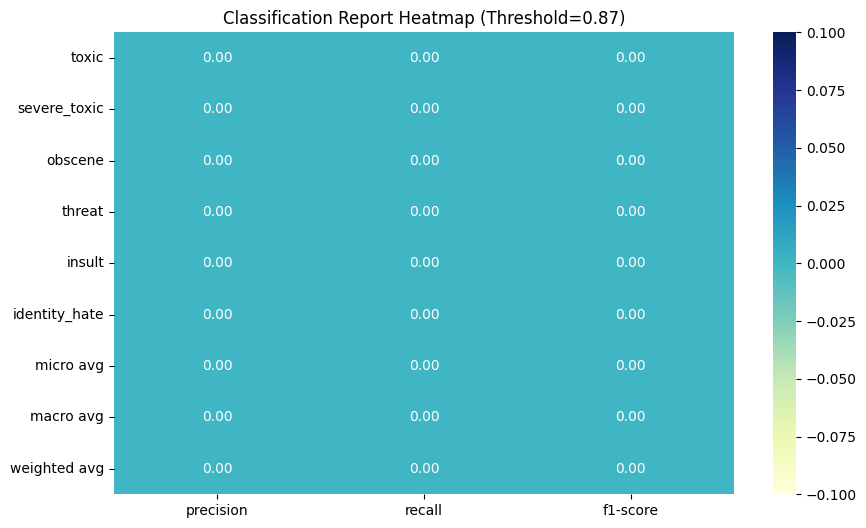

In [28]:
# Threshold spaces
class_names = dataframe.iloc[:, 1:-1].columns.tolist()  # Get class names from the dataframe

for threshold in threshold_list:
    print(f"Threshold: {threshold}")
    print("===========================")

    # Binarize outputs based on threshold
    binary_outputs = (outputs > threshold).astype(int)

    # Generate the classification report
    report = metrics.classification_report(targets, binary_outputs, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()

    # Rename index to class names for readability
    for i in range(len(class_names)):
        report_df.rename(index={str(i): class_names[i]}, inplace=True)

    # Plot heatmap for the current threshold
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", cbar=True, fmt=".2f")
    plt.title(f"Classification Report Heatmap (Threshold={threshold:.2f})")
    plt.show()


We could see from this values that they are not predicting any value correcly to some classes so we need  to figure it out to solve it.

Threshold: 0.56


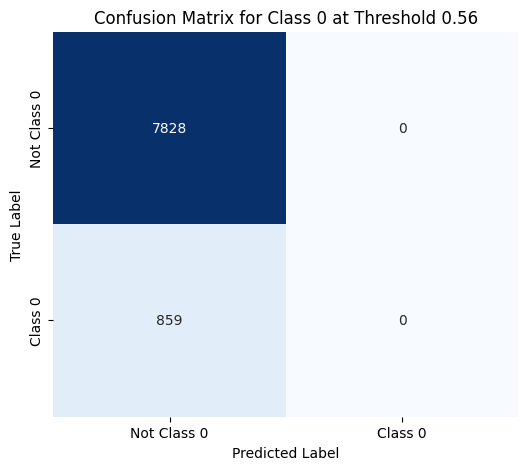

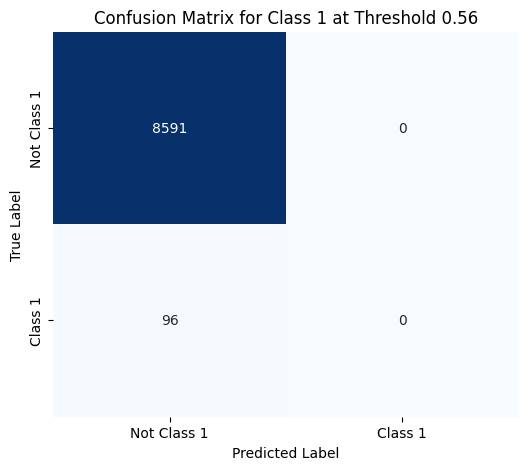

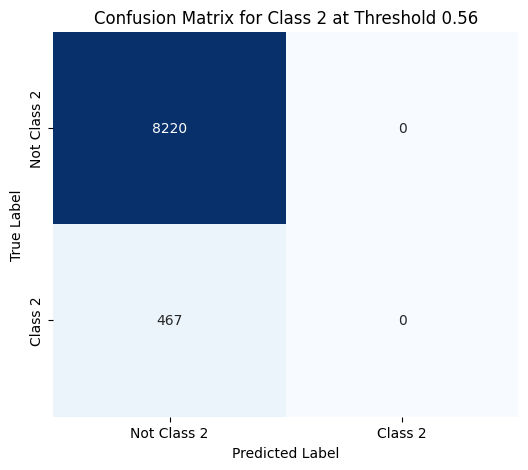

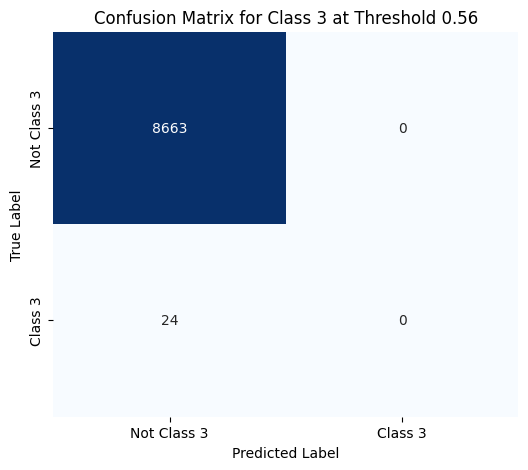

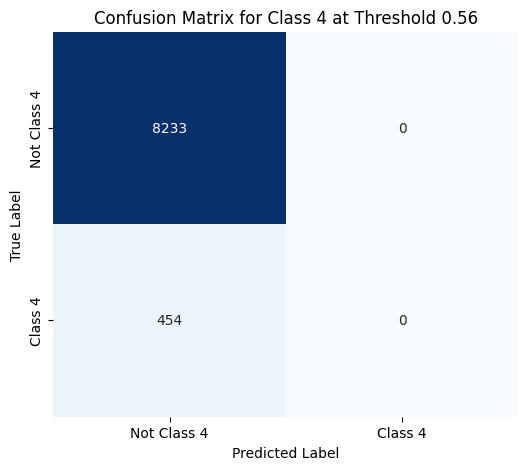

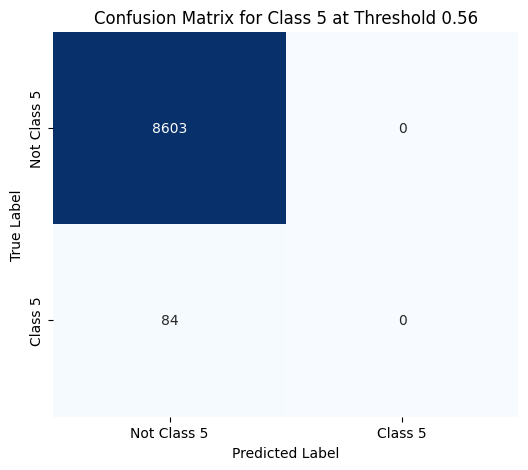

Threshold: 0.75


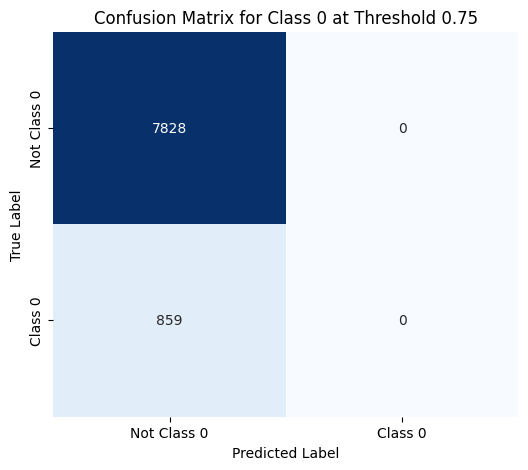

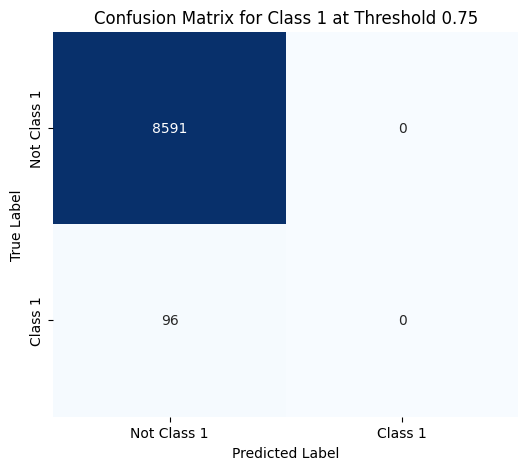

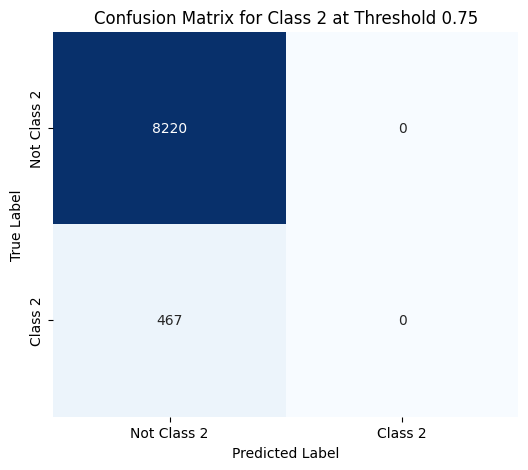

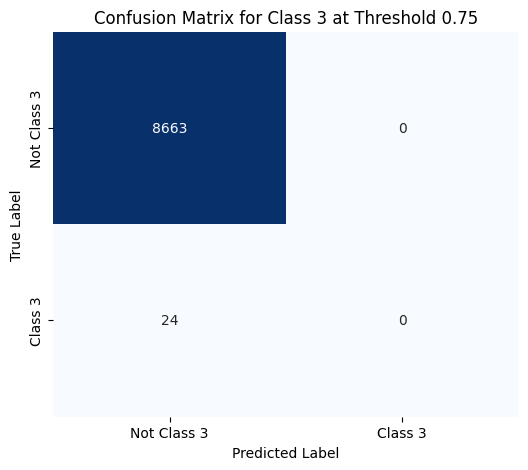

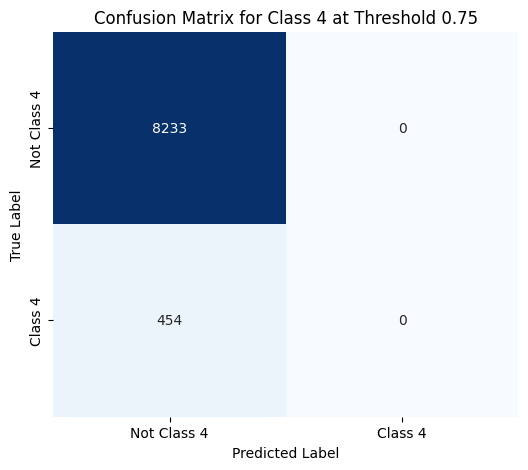

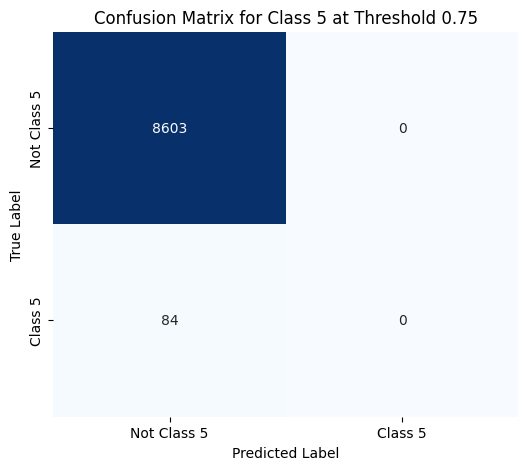

Threshold: 0.87


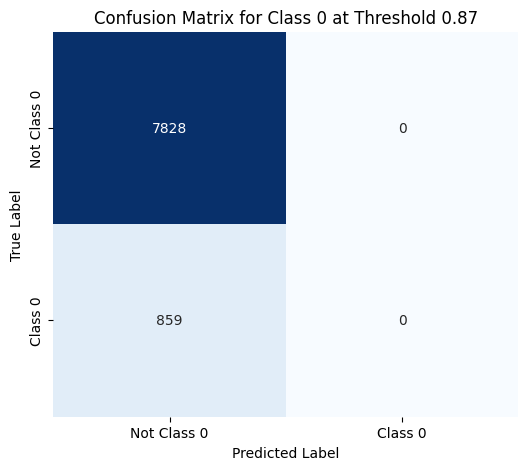

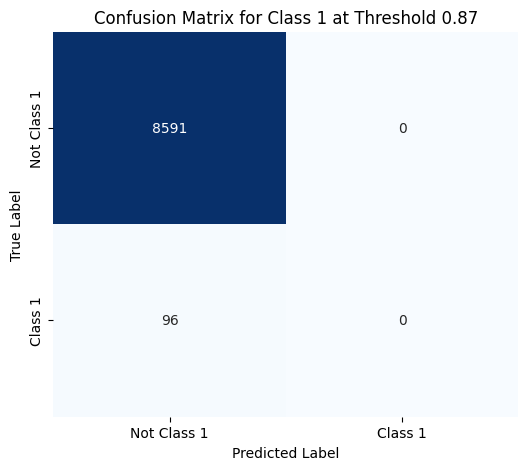

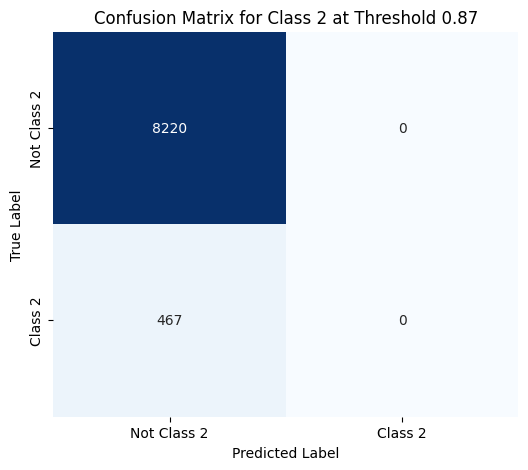

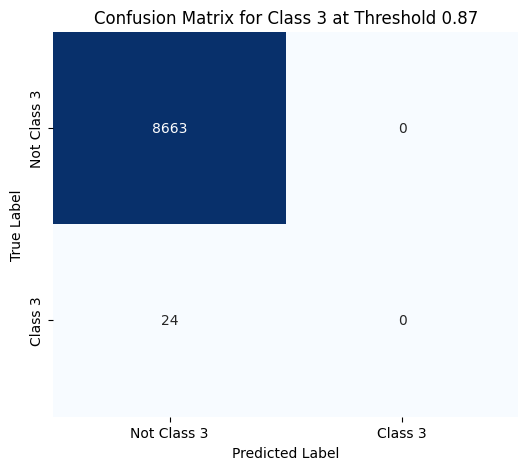

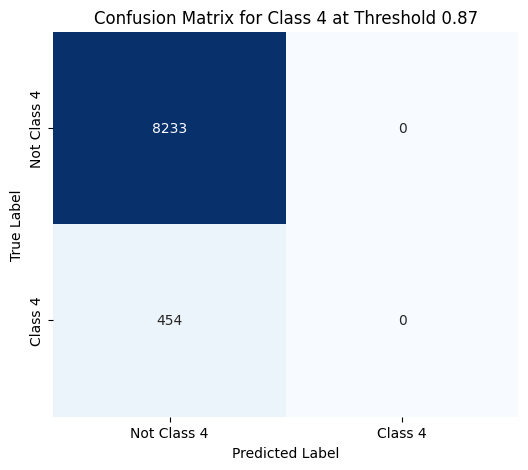

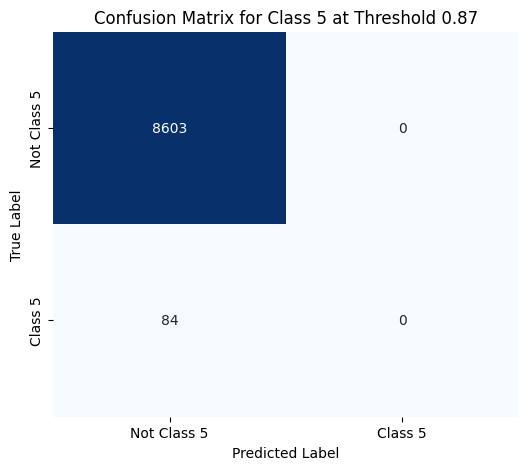

In [29]:
# Loop through each threshold
for threshold in threshold_list:
    print(f"Threshold: {threshold}")
    print("===========================")

    # Convert model outputs to binary predictions using the current threshold
    outputs_binary = (outputs > threshold).astype(int)  # Adjust this line based on your actual outputs

    # Calculate confusion matrices for each class
    conf_matrices = multilabel_confusion_matrix(targets, outputs_binary)

    # Plot each confusion matrix for the current threshold
    for i, conf_matrix in enumerate(conf_matrices):
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=[f"Not Class {i}", f"Class {i}"],
                    yticklabels=[f"Not Class {i}", f"Class {i}"])
        plt.title(f'Confusion Matrix for Class {i} at Threshold {threshold:.2f}')
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

The model performs well for certain classes like toxic and insult, with relatively higher precision and recall, but struggles with others, notably identity_hate and severe_toxic, where it achieves low or even zero scores. This suggests the model has difficulty identifying nuances in some categories, potentially due to class imbalance or insufficient feature learning.

# Summary

We conducted several experiments using different threshold values. At thresholds of around 20% and 40%, the model's performance was poor: it achieved a perfect recall but with 0% accuracy. This indicated that the model was classifying all samples into a single class, failing to differentiate between classes effectively.

However, at a threshold of 56%, the model achieved balanced performance. This threshold seemed to yield the best trade-off between recall and accuracy, avoiding the issues seen with lower thresholds. Increasing the threshold above 56% led to a decline in performance. Based on these results, we suggest setting the threshold around 56% to optimize the model's effectiveness.